# Emotion Recognition Using Deep Learning

**Group Members:**

- Aydin Bagiyev (abagiyev@gwu.edu)
- Narmin Jamalova (Aydin's awesome!!! lovely girlfriend! njamalova54@gwu.edu)

# General Setups
### Install Libraries

In [1]:
!pip install torchdata
!pip install imblearn

     |████████████████████████████████| 23.2 MB 48.5 MB/s eta 0:00:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.23.2
    Uninstalling scikit-learn-0.23.2:
      Successfully uninstalled scikit-learn-0.23.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pdpbox 0.2.1 requires matplotlib==3.1.1, but you have matplotlib 3.4.3 which is incompatible.
hypertools 0.7.0 requires scikit-learn!=0.22,<0.24,>=0.19.1, but you have scikit-learn 1.0.1 which is incompatible.


### Import Libraries

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as image

import torch


from torchvision import transforms


%matplotlib inline

### Globals Variables

In [3]:
# below variables are established to be used throughout the notebook without being subjected to any change
BATCH_SIZE     = 64
HEIGHT = WIDTH = 48
NCHANNELS      =  3

OPTIMIZER      = "adam"

TRANSFORMER    = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(.485, .456, .406), std=(.229, .224, .225)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=90),
])

EPOCHS         = 50

EMOTIONS       = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

LIMIT          = 1000

DEVICE         = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


### Notes
1. For visualization purposes **test** key word has been replaced with **trial** in variable naming to keep character numbers equal to `5`
2. **UPPER CASE** words are global variables. They are declared and maintaned only above.

# MILESTONE - I
### Import Libraries

In [4]:
import os
import re

import numpy as np
import pandas as pd

import cv2
import PIL.Image as Image

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

from imblearn.over_sampling import SMOTE

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

**Task 1:** Load data correctly and show contents in a cell.

> 1. Database is already divided into test and train in the emotion named folders but it is required to have label data to start working. While doing this, all the data has been combined under unique set which will be seperated later according to the **20/80** rule.
2. A sample of each emotion is illustrated by looping through each emotion sub-folder and looking up the first image to plot as an example. Each example image is annotated with the emotion label assigned to it.

In [5]:
paths   = []
labels  = []

base = f"../input/fer2013/"

if os.path.exists(path=base) and os.path.isdir(base):
    for level_1_dir in os.listdir(path=base): # train/test
        level_1_path = f"{level_1_dir}"
        if os.path.exists(path=base + level_1_path) and os.path.isdir(base + level_1_path):
            for level_2_dir in os.listdir(path=base + level_1_path): # 7 emotions
                level_2_path =f"{level_1_path}/{level_2_dir}"
                if os.path.exists(path=base + level_2_path) and os.path.isdir(base + level_2_path):
                    for file in os.listdir(path=base + level_2_path): # files
                        file_path = f"{level_2_path}/{file}"
                        if os.path.isfile(base + file_path):
                            paths.append(file_path)
                            labels.append(level_2_dir)

df = pd.DataFrame({'path': [base + path for path in paths], 'label': labels})

In [6]:
# create a new column to store the images as ndarray
df['img_as_matrix'] = df['path'].apply(lambda path: cv2.imread(path))

# view firts 5 rows of the newly created dataframe
df.head()

,path,label,img_as_matrix
0,../input/fer2013/test/surprise/PublicTest_7868...,surprise,"[[[54, 54, 54], [54, 54, 54], [54, 54, 54], [5..."
1,../input/fer2013/test/surprise/PrivateTest_585...,surprise,"[[[199, 199, 199], [199, 199, 199], [199, 199,..."
2,../input/fer2013/test/surprise/PrivateTest_837...,surprise,"[[[255, 255, 255], [253, 253, 253], [255, 255,..."
3,../input/fer2013/test/surprise/PublicTest_8442...,surprise,"[[[244, 244, 244], [241, 241, 241], [247, 247,..."
4,../input/fer2013/test/surprise/PrivateTest_879...,surprise,"[[[52, 52, 52], [50, 50, 50], [49, 49, 49], [4..."


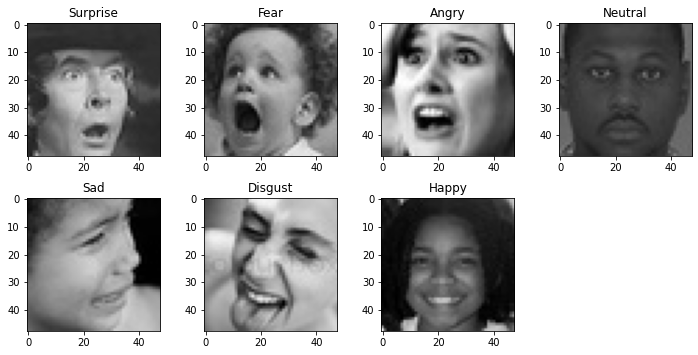

In [7]:
# set plotting options
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, _)) = plt.subplots(2, 4, figsize=(10, 5))
_.set_visible(False)

for index, label in enumerate(df['label'].unique()):
    img = df[df['label'] == label]['img_as_matrix'].iloc[0]
    
    exec(f"ax{index + 1}.imshow(img)")
    exec(f"ax{index + 1}.set_title(label.title())")
    
fig.tight_layout()

**Task 3:** For imagery datasets, provide the "average image" for each class.


> In this section, an average image per emotion class is displayed. The average image is computed by adding together the array representations of each image in the emotion sub-folder and dividing that sum by the total number of images in the sub-folder to find the mean.

*The resulting average images per emotion class are then displayed.*

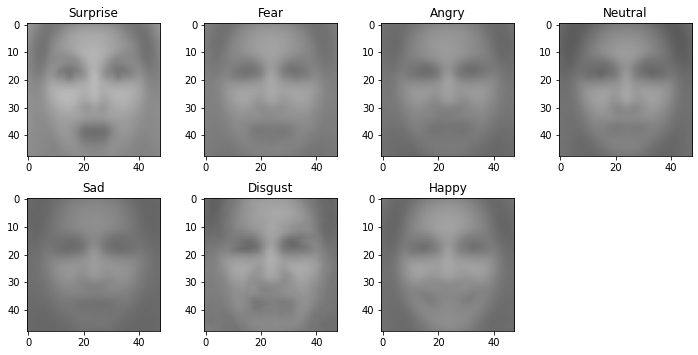

In [8]:
# setplotting options
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, _)) = plt.subplots(2, 4, figsize=(10, 5))
_.set_visible(False)

for index, label in enumerate(df['label'].unique()):
    avg_img = np.stack(df[df['label'] == label]['img_as_matrix']).mean(axis=0).astype(np.uint8)
    
    exec(f"ax{index + 1}.imshow(avg_img)")
    exec(f"ax{index + 1}.set_title(label.title())")
    
fig.tight_layout()

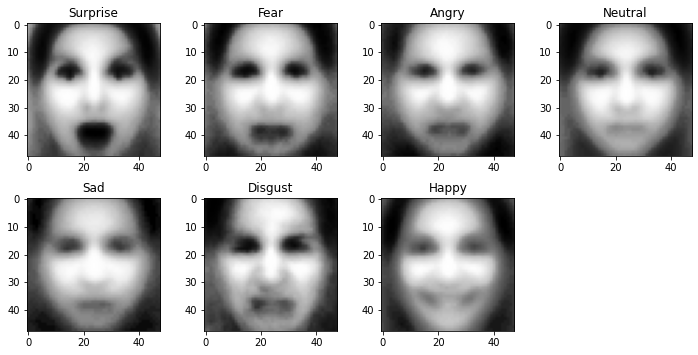

In [9]:
# set plotting options - equalized images for more transparent view
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, _)) = plt.subplots(2, 4, figsize=(10, 5))
_.set_visible(False)

for index, label in enumerate(df['label'].unique()):
    avg_img   = np.stack(df[df['label'] == label]['img_as_matrix']).mean(axis=0).astype(np.uint8)
    
    R, G, B   = cv2.split(avg_img)

    output1_R = cv2.equalizeHist(R)
    output1_G = cv2.equalizeHist(G)
    output1_B = cv2.equalizeHist(B)

    equ = cv2.merge((output1_R, output1_G, output1_B))
    
    exec(f"ax{index + 1}.imshow(equ)")
    exec(f"ax{index + 1}.set_title(label.title())")
    
fig.tight_layout()

**Task 5:** Discussion of how the dataset distribution can/will affect your modeling.

> Depending on how over- or under-represented some emotions are, the model can learn a skewed pattern and hence, not generalize well enough when it comes to test data. For instance, in the cell below, we're plotting the number of images per emotion class to understand the underlying distribution. As can be observed, the representation of different classes is dramatically different from others: e.g., `disgust` is under-represented, while `happy` is over-represented. This means that our model can be skewed in its predictions due to such discrepancies and hence, imbalance will have to be handled.

<BarContainer object of 7 artists>

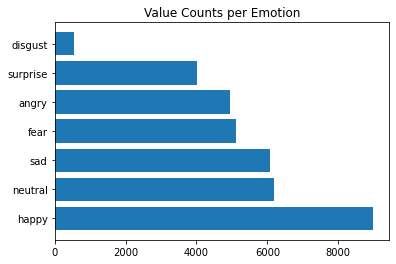

In [10]:
plt.title('Value Counts per Emotion')
plt.barh(y = df.label.value_counts().index, width = df.label.value_counts().values)

**Task 6 and 7:** Handle any missing data. For imagery datasets, discuss what images you might drop and why. The holdout dataset also contains missing data/bad images. Discuss how you handled this in your holdout.
> 1. There are images that are far off from the way an average image looks like in an emotion category. To solve this, we find an average image per emotion class, compute the mean error for each image and find whether the mean error is within standard deviation limits. If the mean error is below or above the standard deviation boundaries, then we consider the image as anomalous and drop it.
2. We perform this for the whole dataset, before splitting it into train / holdout.
3. In the future, we plan to apply augmentations to images to increase their quality / contrast. For example, adding salt and pepper noise to the train dataset will help to train the model to predict more or less accurately on the bad holdout images.

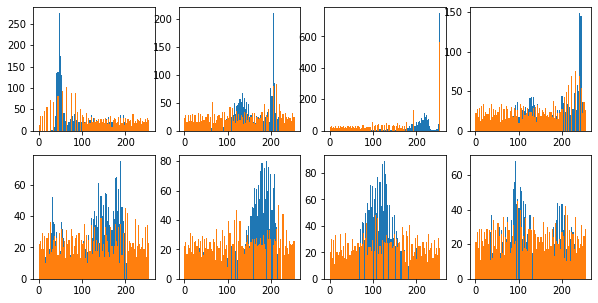

In [11]:
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, figsize=(10, 5))

for index, img in enumerate(df['img_as_matrix'][:8]):
        
    # calculate mean value from RGB channels and flatten to 1D array
    img_1_chan = img.mean(axis=2).flatten().astype(np.uint8)
    
    # gett same 
    equ = cv2.equalizeHist(img_1_chan)
    
    exec(f"ax{index + 1}.hist(img_1_chan, bins=100, range=(0, 255))")
    exec(f"ax{index + 1}.hist(equ, bins=100, range=(0, 255))")

In [12]:
# store the average image per emotion
average_image_per_label = {}

# compute the average image per label
for index, label in enumerate(df['label'].unique()):
    avg_img = np.stack(df[df['label'] == label]['img_as_matrix']).mean(axis=0).astype(np.int8)
    
    # store the result
    average_image_per_label[label] = avg_img

In [13]:
# store deltas between each image and its label's average
deltas = []

for i in range(len(df)):
    label = df.loc[i, 'label']
    # find the delta between each image and its label's average
    delta = np.absolute(average_image_per_label[label] - df.loc[i, 'img_as_matrix'].astype(np.int8))
    deltas.append(delta)
    
df['delta_vs_avg_image'] = deltas

In [14]:
# find the mean error across all channels
df['mean_error'] = df['delta_vs_avg_image'].apply(lambda x: x.mean())

In [15]:
# find an average mean error per group
mean_errors_per_label = df.groupby('label')['mean_error'].mean()

# store standard deviations
error_stds = []

for i in range(len(df)):
    label = df.loc[i, 'label']
    # compute variance between mean error of each image and average error for label
    var = abs(df.loc[i, 'mean_error'] - mean_errors_per_label[label])**2
    # compute standard deviation from variance
    std = np.sqrt(var)
    # store the result
    error_stds.append(std)
    
df['error_std'] = error_stds

In [16]:
df.head()

,path,label,img_as_matrix,delta_vs_avg_image,mean_error,error_std
0,../input/fer2013/test/surprise/PublicTest_7868...,surprise,"[[[54, 54, 54], [54, 54, 54], [54, 54, 54], [5...","[[[99, 99, 99], [93, 93, 93], [88, 88, 88], [8...",61.192708,10.591204
1,../input/fer2013/test/surprise/PrivateTest_585...,surprise,"[[[199, 199, 199], [199, 199, 199], [199, 199,...","[[[46, 46, 46], [52, 52, 52], [57, 57, 57], [6...",44.242188,6.359317
2,../input/fer2013/test/surprise/PrivateTest_837...,surprise,"[[[255, 255, 255], [253, 253, 253], [255, 255,...","[[[102, 102, 102], [106, 106, 106], [113, 113,...",75.538628,24.937124
3,../input/fer2013/test/surprise/PublicTest_8442...,surprise,"[[[244, 244, 244], [241, 241, 241], [247, 247,...","[[[91, 91, 91], [94, 94, 94], [105, 105, 105],...",58.641493,8.039988
4,../input/fer2013/test/surprise/PrivateTest_879...,surprise,"[[[52, 52, 52], [50, 50, 50], [49, 49, 49], [4...","[[[101, 101, 101], [97, 97, 97], [93, 93, 93],...",44.503038,6.098467


In [17]:
# compute standard deviation boundaries
min_std = df['error_std'].min()
max_std = df['error_std'].max()


# treat the image as anomalous if its mean error is below or above standard deviation boundaries.
def get_anomalous_point(mean_error: float, min_std: float, max_std: float): 
    return mean_error < min_std or mean_error > max_std
    
# mark images as anomalous or not
df['check_for_anomalies'] = df['mean_error'].apply(
    lambda err: get_anomalous_point(err, min_std, max_std)
)

In [18]:
# retrieve indices of the anomalous images to drop
image_indices_to_drop = list(df[df['check_for_anomalies'] == True].index)

# drop anomalous image indices,reset index, and update dataframe
df = df.drop(image_indices_to_drop).reset_index(drop=True)

In [19]:
# print planned to be dropped indices
print(f"How many images gets dropped: {len(image_indices_to_drop)}\nSome samples: {image_indices_to_drop[:20]}\n")

print("Printing first 5 rows from dataframe")
df.head()

How many images gets dropped: 9143
Some samples: [0, 2, 10, 16, 17, 27, 32, 34, 35, 39, 45, 46, 48, 52, 60, 66, 71, 73, 74, 80]

Printing first 5 rows from dataframe


,path,label,img_as_matrix,delta_vs_avg_image,mean_error,error_std,check_for_anomalies
0,../input/fer2013/test/surprise/PrivateTest_585...,surprise,"[[[199, 199, 199], [199, 199, 199], [199, 199,...","[[[46, 46, 46], [52, 52, 52], [57, 57, 57], [6...",44.242188,6.359317,False
1,../input/fer2013/test/surprise/PublicTest_8442...,surprise,"[[[244, 244, 244], [241, 241, 241], [247, 247,...","[[[91, 91, 91], [94, 94, 94], [105, 105, 105],...",58.641493,8.039988,False
2,../input/fer2013/test/surprise/PrivateTest_879...,surprise,"[[[52, 52, 52], [50, 50, 50], [49, 49, 49], [4...","[[[101, 101, 101], [97, 97, 97], [93, 93, 93],...",44.503038,6.098467,False
3,../input/fer2013/test/surprise/PrivateTest_909...,surprise,"[[[46, 46, 46], [45, 45, 45], [44, 44, 44], [4...","[[[107, 107, 107], [102, 102, 102], [98, 98, 9...",41.478299,9.123206,False
4,../input/fer2013/test/surprise/PrivateTest_275...,surprise,"[[[125, 125, 125], [130, 130, 130], [130, 130,...","[[[28, 28, 28], [17, 17, 17], [12, 12, 12], [1...",35.719184,14.882321,False


**Task 9**: If you are using images/text, discuss whether you are performing classification or regression on your dataset and why (instead of the other one).

> We are performing a classification on our dataset and the reason is that we have non-continuous values as our y-labels (in this instance, emotion classes). Regression could have been used if we were trying to predict a continuous value but here the prediction target is discrete.

**Task 14:** Discuss and implement how you will handle any dataset imbalance.

There are a number of ways to deal with data imbalance:
> 1. *Over-sampling the under-represented class*. However, given the big discrepancy in the counts between such classes as `surprise` and `happy`, this method might cause the model to overfit.
2. *Under-sampling the over-represented class*. However, this can result in a loss of big amounts of useful data.
3. ***SMOTE (Synthetic Minority Oversampling Technique)***. This method selects examples of data in the feature space (a data point and its nearest neighbor), and then creates a synthetic data point in-between them. In essence, this is an augmentation technique to add varying copies of existing data. We chose to go with this option since we do not want to lose data and do not want to experience the effects of over-fitting.

In [20]:
# label encoding
df['labels_numeric'] = [EMOTIONS.index(label) for label in df['label']]

In [21]:
# assigning labels to y
y = df['labels_numeric']

# X is a list of read-in images
X = np.stack(df['img_as_matrix'])

# get all dimensions of the resulting X
n_samples, height, width, n_channels = [X.shape[index] for index in range(4)]

print(f"Shape of X before reshape: {X.shape}")

# reshape X because SMOTE accepts only (n_samples, n_channels*height*weight)-type data
X_reshaped = X.reshape(n_samples, n_channels*height*width)

print(f"Shape of X before reshape: {X.shape}")

Shape of X before reshape: (26744, 48, 48, 3)
Shape of X before reshape: (26744, 48, 48, 3)


In [22]:
# initialize the SMOTE model
smote = SMOTE(random_state=62)

# perform re-sampling on modified X given y
X_smote, y_smote = smote.fit_resample(X_reshaped, y)

In [23]:
print(f'Before re-sampling, the amount of images:  {len(X):6}')
print(f'After re-sampling, the amount of images :{len(X_smote):8}')

Before re-sampling, the amount of images:   26744
After re-sampling, the amount of images :   49154


<BarContainer object of 7 artists>

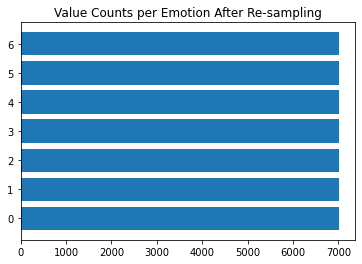

In [24]:
# view the resulting balanced data(modified distribution)
plt.title('Value Counts per Emotion After Re-sampling')
plt.barh(y = y_smote.value_counts().index, width = y_smote.value_counts().values)

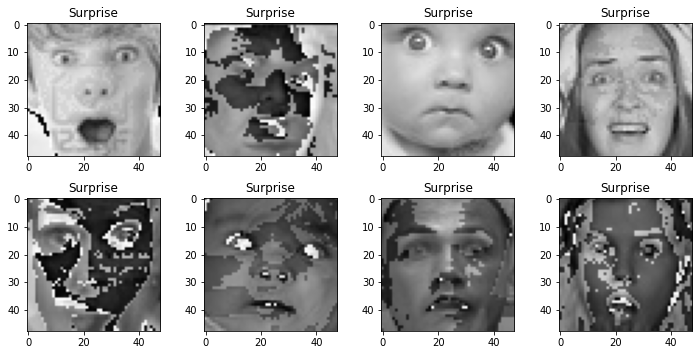

In [25]:
# set plotting options
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, figsize=(10, 5))
_.set_visible(False)

# reshape each SMOTE image into (h, w, n_channels) format
for index, (image, label) in enumerate(zip(X_smote[-9:-1], y_smote[-9:-1])):
    img_to_plot = image.reshape((HEIGHT, WIDTH, NCHANNELS))
    
    exec(f"ax{index + 1}.imshow(img_to_plot)")
    exec(f"ax{index + 1}.set_title(EMOTIONS[label].title())")
    
fig.tight_layout()

### Limiting Dataset Size

In [26]:
# each category is limited to 1000 samples for easy training
limit_counter = {i:0 for i, _ in enumerate(EMOTIONS)}

X_smote_limited = []
y_smote_limited = []

for x, y in zip(X_smote, y_smote):
    if limit_counter[y] < LIMIT:
        X_smote_limited.append(x)
        y_smote_limited.append(y)
        
        limit_counter[y] += 1

X_smote_limited = np.array(X_smote_limited)
y_smote_limited = pd.Series(data=y_smote_limited)

**Task 3:** Correct explanation generalization from such a holdout split.
> For the train / test split the following percentages were chosen: 80%-20%. Of the 80% coming from the train set, 20% is the validation set. Since the data is already balanced, the choice of a random split is a reasonable one.

**Task 13**: Separate your training data into features and labels.
> For the latter task both PYTORCH and KERAS packages are used and therefore, splitting phase has been forked into 2 parts for each distribution.

In [27]:
# split data into train, valid and test for KERAS
X_keras_train, X_keras_remained, y_keras_train, y_keras_remained = train_test_split(
    X_smote_limited, y_smote_limited, test_size=0.20, random_state=42
)

X_keras_valid, X_keras_trial, y_keras_valid, y_keras_trial = train_test_split(
    X_keras_remained, y_keras_remained, test_size=0.50, random_state=42
)

In [28]:
# convert X and y to Tensors
X_torch_smote = torch.Tensor(X_smote_limited)
y_torch_smote = torch.as_tensor(y_smote_limited, device=torch.device('cuda'))

# split data into train, valid and test
X_torch_train, X_torch_remained, y_torch_train, y_torch_remained = train_test_split(
    X_torch_smote, y_torch_smote, test_size=0.20, random_state=42
)
X_torch_valid, X_torch_trial, y_torch_valid, y_torch_trial = train_test_split(
    X_torch_remained, y_torch_remained, test_size=0.50, random_state=42
)

In [29]:
def change_shape(key, X, y, shape):
    # print initial shape of the datasets
    print(f'Before {key.upper()} datasets:\n\tX dataset: {X[key].shape}\n\ty dataset: {y[key].shape}\n')

    # reshape to remove the requirements of SMOTE that do not suit standard model training
    X[key] = X[key].reshape((X[key].shape[0], shape[0], shape[1], shape[2]))

    # print latest shape of the datasets
    print(f'After {key.upper()} datasets:\n\tX {key} dataset: {X[key].shape}\n\ty {key} dataset: {y[key].shape}\n')

### Reshape Datasets

In [30]:
# store datasets in a dict for easy use 
X_keras_dict = {
    "train": X_keras_train, 
    "valid": X_keras_valid, 
    "trial": X_keras_trial
}

y_keras_dict = {
    "train": y_keras_train, 
    "valid": y_keras_valid, 
    "trial": y_keras_trial
}

In [31]:
# reshape KERAS datasets
input_keras_shape = (HEIGHT, WIDTH, NCHANNELS)

change_shape("train", X_keras_dict, y_keras_dict, input_keras_shape)
print()
change_shape("valid", X_keras_dict, y_keras_dict, input_keras_shape)
print()
change_shape("trial", X_keras_dict, y_keras_dict, input_keras_shape)

Before TRAIN datasets:
	X dataset: (5600, 6912)
	y dataset: (5600,)

After TRAIN datasets:
	X train dataset: (5600, 48, 48, 3)
	y train dataset: (5600,)


Before VALID datasets:
	X dataset: (700, 6912)
	y dataset: (700,)

After VALID datasets:
	X valid dataset: (700, 48, 48, 3)
	y valid dataset: (700,)


Before TRIAL datasets:
	X dataset: (700, 6912)
	y dataset: (700,)

After TRIAL datasets:
	X trial dataset: (700, 48, 48, 3)
	y trial dataset: (700,)



In [32]:
# store datasets in a dict for easy use 
X_torch_dict = {
    "train": X_torch_train, 
    "valid": X_torch_valid, 
    "trial": X_torch_trial, 
    "total": X_torch_smote
}

y_torch_dict = {
    "train": y_torch_train, 
    "valid": y_torch_valid, 
    "trial": y_torch_trial, 
    "total": y_torch_smote
}

In [33]:
# reshape PYTORCH datasets
input_torch_shape = (NCHANNELS, HEIGHT, WIDTH)

change_shape("train", X_torch_dict, y_torch_dict, input_torch_shape)
print()
change_shape("valid", X_torch_dict, y_torch_dict, input_torch_shape)
print()
change_shape("trial", X_torch_dict, y_torch_dict, input_torch_shape)

Before TRAIN datasets:
	X dataset: torch.Size([5600, 6912])
	y dataset: torch.Size([5600])

After TRAIN datasets:
	X train dataset: torch.Size([5600, 3, 48, 48])
	y train dataset: torch.Size([5600])


Before VALID datasets:
	X dataset: torch.Size([700, 6912])
	y dataset: torch.Size([700])

After VALID datasets:
	X valid dataset: torch.Size([700, 3, 48, 48])
	y valid dataset: torch.Size([700])


Before TRIAL datasets:
	X dataset: torch.Size([700, 6912])
	y dataset: torch.Size([700])

After TRIAL datasets:
	X trial dataset: torch.Size([700, 3, 48, 48])
	y trial dataset: torch.Size([700])



**Task 2:** Holdout dataset split as specified.

In [34]:
# create train, test and validation datasets for the data loader
train_dataset = TensorDataset(X_torch_dict["train"], y_torch_dict["train"])
valid_dataset = TensorDataset(X_torch_dict["valid"], y_torch_dict["valid"])
trial_dataset = TensorDataset(X_torch_dict["trial"], y_torch_dict["trial"])

**Task 8:** Discuss (and implement if applicable) whether or not you need to scale/normalize your features, and which ones, if any.

> 1. Scaling is important to ensure that all images are of the same size and hence, can be accepted by the model. Our image dataset is already well-scaled, with a fixed height and weight parameters as defined at the beginning of this notebook.
2. Normalization in our image dataset is needed so that each image has similar pixel distribution. This way we reduce the skewness in our dataset.

**Task 12**: What customized dataset augmentation you would use (not required to implement) for images?

> 1. improving the contrast on the images (adaptive equalization)
2. applying flipping, rotations to stabilize model performance regardless of angle
3. fill in the gaps on the image to the nearest pixel

In [35]:
# apply transformations to the train set
train_dataset.transform = TRANSFORMER

# apply transformations to the validation set
valid_dataset.transform = TRANSFORMER

# apply transformations to the test set
trial_dataset.transform = TRANSFORMER

# create a dataloader for each subset of data
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
trial_loader = DataLoader(trial_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

The dataloaders are set up in the cell above for all three data subsets: train, validation and test. `BATCH_SIZE` was chosen to be 64, which is rather small, however, it means the model can start learning better since the number of parameters it needs to update per epoch is now higher. `shuffle` is set to `True` so that at each epoch the data gets re-shuffled which helps avoid under- or over-fitting. `drop_last` is set to `True` to avoid cases where a batch contains just one sample image.

**Task 9**: If you are using images/text, discuss whether you are performing classification or regression on your dataset and why (instead of the other one).

> We are performing a classification on our dataset and the reason is that we have non-continuous values as our y-labels (in this instance, emotion classes). Regression could have been used if we were trying to predict a continuous value but here the prediction target is discrete.

**Task 10:** Give an example of an ordinal feature that you've seen used by others, when it should have been treated as a categorical.

> Example: `color` feature (red, green, blue). People might assume there's a color order, but in fact this is a categorical feature, since there's no particular ordering (and if there is, it's a rather complex one). We can treat different pixel intensities within `green` as an ordinal feature, but not when it comes to differing colors such as `green` vs `red`.

**Task 11**: For imagery/text: Show a histogram of the distribution of pixels or word embeddings across your dataset.

In [36]:
# count number of times a color appears
color_counts = {}

for img in df.loc[:, 'img_as_matrix']:
    # flatten the image into 1 channel
    img_1_channel = img.mean(axis=2).flatten().astype(np.uint8)
    # count each color occurrence
    for color in img_1_channel:
        try:
            color_counts[color] += 1
        except:
            color_counts[color] = 1

<BarContainer object of 256 artists>

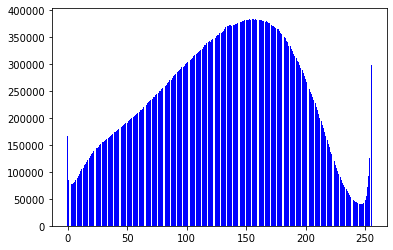

In [37]:
# view pixel distribution across the original dataset
plt.bar(color_counts.keys(), color_counts.values(), color='b')

# MILESTONE - II
### Import Libraries

In [58]:
import torchvision

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn import metrics

import torch
import torch.optim as optim
import torch.nn as nn

import tensorflow as tf
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D

**Task 15:** Instantiate a model of your choosing.

In [39]:
def build_classifier(optimizer="adam"):
    """
    The model is based on 4 convolutional layers."""
    cnn4 = Sequential()
    cnn4.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_keras_shape))
    cnn4.add(BatchNormalization())

    cnn4.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    cnn4.add(BatchNormalization())
    cnn4.add(MaxPooling2D(pool_size=(2, 2)))
    cnn4.add(Dropout(0.25))

    cnn4.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    cnn4.add(BatchNormalization())
    cnn4.add(Dropout(0.25))

    cnn4.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    cnn4.add(BatchNormalization())
    cnn4.add(MaxPooling2D(pool_size=(2, 2)))
    cnn4.add(Dropout(0.25))

    cnn4.add(Flatten())

    cnn4.add(Dense(512, activation='relu'))
    cnn4.add(BatchNormalization())
    cnn4.add(Dropout(0.5))

    cnn4.add(Dense(128, activation='relu'))
    cnn4.add(BatchNormalization())
    cnn4.add(Dropout(0.5))

    cnn4.add(Dense(len(EMOTIONS), activation='softmax'))

    cnn4.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=["categorical_accuracy"])
    
    return cnn4

# establish estimator
estimator = KerasClassifier(build_fn=build_classifier)

**Task 16:** Define a grid to tune at least three different hyperparameters with at least two different values each. Discuss why you think these parameter values might be useful for this dataset.

> Upon researching, we found that the below chosen hyper-parameters are the most commonly used and the most effective in fine-tuning the modelling process. Therefore, these parameters are of interest to see how our model performs with each of them and which set is the best.

In [40]:
# # choose the hyperparameter values to try
# params = {
#     "batch_size" : [32],        
#     "epochs"     : [1],        
#     "optimizer"  : ["adam"], 
# }

In [41]:
# choose the hyperparameter values to try
params = {
    "batch_size" : [25, 32, 64],        
    "epochs"     : [2, 3, 4],        
    "optimizer"  : ["adam", "rmsprop"], 
}

**Task 17:** Set up a gridsearchCV with 5-fold cross validation (scikit-learn) or equivalent in PyTorch. Discuss what accuracy metric you chose and why.
    
    In our task our main desire it to find the image labeling correct most of the time, but if we fail it is not  critical. Therefore, most of the time the accuracy is a right metric.
> 1. F1 Score would be suitable for the case, since it tries to find the balance between precision and recall.
2. Recall can also be suitable for the case, since it answers the question "how many relevant items has been choosen?"

In [42]:
# grid = GridSearchCV(estimator=estimator, param_grid=params, cv=5, scoring="accuracy")

**Task 18:** Train your model using grid search, and report the best performing hyperparameters.

In [43]:
# fit the grid on our train data and print the best scores
# grid.fit(X_keras_dict["train"], y_keras_dict["train"])
# print("Best: %f using %s" % (grid.best_score_, grid.best_params_))

In [44]:
# # compute predictions on the holdout
# y_pred = grid.predict(X_keras_dict["trial"])
# y_true = y_keras_dict["trial"].values

**Task 19:** Calculate accuracy, precision and recall on the holdout dataset. Discuss which metric you think is most meaningful for this dataset, and why

> *Precision* and *Recall*, both are very important in the content. But in any case if you desire to have high precision then you sacrifice recall and vice versa. In the particular usage, precision is slightly over weigting since having any false negative does not have a high cost contrast to sick patients example. However, in the particular dataset, we are looking for getting as much correct answer as possible and therefore, *Accuracy* is the correct metric to go with.

In [45]:
# # print classification report
# print(classification_report(y_true, y_pred))

**Task 20:** Discuss how the model performance on holdout compares to the model performance during training. Do you think your model will generalize well? Why or why not?

> Since we are using SMOTE technique, the results are not expected to generalize well due to the fact that there is a very low representation of the `disgust` label in our dataset, and hence SMOTE method can be ineffective in model fine-tuning. If, however, we were to drop the `disgust` label instead, and equalize the other labels in terms of their size to the second lowest label (around 4,000), then the results could have been generalizable. So, we traded-off the better accuracy score for the implementation of a new method not widely tried before.

The model above has a slightly lower accuracy score during training (vs the score achieved on hold-out) due to possible underfitting as a result of the paragraph above. Moreover, due to using Kaggle, we had resource limitations in terms GPU and memory and hence, could not train for more epochs and had to limit the dataset size to 1,000 samples per category.

**Task 21:** Generate a confusion matrix and discuss your results.
> In confusion matrix the desired output is to have all zero except diagonal. `happy` and `neutral` labels are the most misclassified ones, due to the fact that `happy` is more representative in the database and hence the model learns more about that label and overfits, whilst `neutral` is hard to identify by image features and often gets mistaken for other emotions. The best classified ones are `surprise`, `angry` and `fear`.


In [46]:
# # compute the confusion matrix
# conf_mat = metrics.confusion_matrix(y_true, y_pred)

# # plot confusion matrix
# metrics.ConfusionMatrixDisplay(conf_mat, display_labels=EMOTIONS).plot()

**Task 22:** Train and tune another type of model on your training dataset. Using the best performing hyperparameters, test this model on your holdout. How did it perform, compared to your earlier model? Do you think your results will generalize?

> Since we are using SMOTE technique, the results are not expected to generalize well due to the fact that there is a very low representation of the `disgust` label in our dataset, and hence SMOTE method can be ineffective in model fine-tuning. If, however, we were to drop the `disgust` label instead, and equalize the other labels in terms of their size to the second lowest label (around 4,000), then the results could have been generalizable. So, we traded-off the better accuracy score for the implementation of a new method not widely tried before.

The model below has a higher accuracy score on the holdout set (vs the score achieved on an earlier model) and the results are not expected to generalize due to the different structures of models and the impact that SMOTE has on them.

In [47]:
# one-hot-encode y dataset for the actual training
y_keras_dict["train_categorical"] = tf.keras.utils.to_categorical(y_keras_dict["train"], len(EMOTIONS))
y_keras_dict["valid_categorical"] = tf.keras.utils.to_categorical(y_keras_dict["valid"], len(EMOTIONS))
y_keras_dict["trial_categorical"] = tf.keras.utils.to_categorical(y_keras_dict["trial"], len(EMOTIONS))

In [48]:
def build_and_run_GridSearchCV(builder, params, cv=5, scoring="accuracy"):
    # build estimator through Keras Classifier
    estimator = KerasClassifier(build_fn=builder, verbose=2)
    
    # establish gridSearchCV
    grid = GridSearchCV(estimator=estimator, param_grid=params, cv=cv, scoring=scoring)

    grid.fit(X_keras_dict["train"], y_keras_dict["train"])
    print("Best: %f using %s" % (grid.best_score_, grid.best_params_))
    
    # set best parameters
    BATCH_SIZE, EPOCHS, OPTIMIZER = grid.best_params_
    
    # compute predictions on the holdout
    y_pred = grid.predict(X_keras_dict["trial"])
    y_true = y_keras_dict["trial"].values
    
    # compute the confusion matrix
    conf_mat = metrics.confusion_matrix(y_true, y_pred)

    # plot confusion matrix
    metrics.ConfusionMatrixDisplay(conf_mat, display_labels=EMOTIONS).plot()

In [49]:
def build_resnet50_model(optimizer="adam"):
    
    # create the base pre-trained model
    base_model = ResNet50(input_shape=input_keras_shape, weights="imagenet", include_top=False)

    # add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # let's add a fully-connected layer
    x = Dense(1024, activation='relu')(x)

    # and a logistic layer -- let's say we have 200 classes
    predictions = Dense(len(EMOTIONS), activation='softmax')(x)

    # create model
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # compile the model (usually should be done *after* setting layers to non-trainable)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [50]:
def build_grid_search_resnet50_model(optimizer="adam"):
    
    model = Sequential()
    
    base_model = ResNet50(input_shape=input_keras_shape, weights="imagenet", include_top=False)

    # add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # let's add a fully-connected layer
    x = Dense(1024, activation='relu')(x)
    
    # and a logistic layer -- let's say we have 200 classes
    predictions = Dense(len(EMOTIONS), activation='softmax')(x)

    # this is the model we will train
    model.add(Model(inputs=base_model.input, outputs=predictions))
    
    model.add(Dense(len(EMOTIONS), activation="softmax"))
    
    # compile the model (usually should be done *after* setting layers to non-trainable)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [51]:
def train_and_evaluate(model):
    
    # train the model on the new data for a few epochs
    print("Training on the TRAIN set:")
    model.fit(X_keras_dict["train"], y_keras_dict["train_categorical"], batch_size=BATCH_SIZE, epochs=EPOCHS)

    # evaluate the model on the test data
    print("\n\nEvaluation on the HOLDOUT set:")
    model.evaluate(X_keras_dict["trial"], y_keras_dict["trial_categorical"], batch_size=BATCH_SIZE)

In [67]:
def save_model(model):
    
    # save the model and its weights
    model.save('./model.h5')
    model.save_weights('./model_weights.h5')

In [53]:
# establish and running gridsearchCV to get best parameters for RESNET50 model
# build_and_run_GridSearchCV(build_grid_search_resnet50_model, params)

In [54]:
# build model
model = build_resnet50_model(OPTIMIZER)

# print details
model.summary()

2021-12-17 16:40:08.626125: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-12-17 16:40:08.628694: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-12-17 16:40:08.631327: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-17 16:40:08.632700: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-12-17 16:40:08.632841: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-12-17 16:40:08.672572: I tensorflow/stream_executor/platform/def

94773248/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 54, 54, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 24, 24, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 24, 24, 64)   256         conv1_conv[0][0]                 
_____________________________

In [55]:
# start training and evaluating the model
train_and_evaluate(model)

Training on the TRAIN set:


2021-12-17 16:40:14.827551: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-12-17 16:40:14.842896: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2199995000 Hz


Epoch 1/50


2021-12-17 16:40:23.195022: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-12-17 16:40:24.270617: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2021-12-17 16:40:24.315058: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


88/88 [==============================] - 21s 61ms/step - loss: 2.1255 - accuracy: 0.3041
Epoch 2/50
88/88 [==============================] - 5s 56ms/step - loss: 1.2475 - accuracy: 0.5386
Epoch 3/50
88/88 [==============================] - 6s 64ms/step - loss: 0.9658 - accuracy: 0.6370
Epoch 4/50
88/88 [==============================] - 5s 54ms/step - loss: 0.7769 - accuracy: 0.7253
Epoch 5/50
88/88 [==============================] - 5s 53ms/step - loss: 0.6829 - accuracy: 0.7579
Epoch 6/50
88/88 [==============================] - 5s 55ms/step - loss: 0.5397 - accuracy: 0.8109
Epoch 7/50
88/88 [==============================] - 5s 54ms/step - loss: 0.4045 - accuracy: 0.8579
Epoch 8/50
88/88 [==============================] - 5s 56ms/step - loss: 0.4264 - accuracy: 0.8531
Epoch 9/50
88/88 [==============================] - 5s 56ms/step - loss: 0.3100 - accuracy: 0.8957
Epoch 10/50
88/88 [==============================] - 5s 56ms/step - loss: 0.2159 - accuracy: 0.9293
Epoch 11/50
88/88 [

In [56]:
# save the model and its weights
save_model(model)

**Continue training for more epochs**: Restart the kernel, re-run needed cells and train for more epochs with the re-loaded model and its weights.

In [59]:
model = load_model('../input/fer2013-resnet-50-epochs/resnet50.h5')
model.load_weights('../input/fer2013-resnet-50-epochs/resnet50_weights.h5')

In [60]:
# continue training and evaluating the model for EPOCHS
train_and_evaluate(model)

Training on the TRAIN set:
Epoch 1/50
88/88 [==============================] - 11s 58ms/step - loss: 0.2641 - accuracy: 0.9107
Epoch 2/50
88/88 [==============================] - 5s 54ms/step - loss: 0.1906 - accuracy: 0.9366
Epoch 3/50
88/88 [==============================] - 5s 60ms/step - loss: 0.1587 - accuracy: 0.9475
Epoch 4/50
88/88 [==============================] - 5s 54ms/step - loss: 0.1417 - accuracy: 0.9527
Epoch 5/50
88/88 [==============================] - 5s 57ms/step - loss: 0.1509 - accuracy: 0.9452
Epoch 6/50
88/88 [==============================] - 5s 54ms/step - loss: 0.1491 - accuracy: 0.9539
Epoch 7/50
88/88 [==============================] - 5s 57ms/step - loss: 0.1451 - accuracy: 0.9500
Epoch 8/50
88/88 [==============================] - 5s 56ms/step - loss: 0.1448 - accuracy: 0.9514
Epoch 9/50
88/88 [==============================] - 5s 57ms/step - loss: 0.1562 - accuracy: 0.9480
Epoch 10/50
88/88 [==============================] - 5s 57ms/step - loss: 0.1233 

In [61]:
# re-save the model and its weights
save_model(model)

**Task 23:** Next, repeat training and tuning on the same data with a third model, dissimilar from the other two. Do you need to do any additional feature cleaning or scaling here? Why or why not?

> The next model tried is VGG16, which is different from the ones above only in terms of its internal structure, i.e. the depth of its layers. Hence, no extra cleaning or scaling is needed.

In [62]:
def build_grid_search_vgg16_model(optimizer="adam"):
    
    # initiate sequential model wrapper
    model = Sequential()
    
    # create the base pre-trained model
    base_model = VGG16(input_shape=input_keras_shape, weights="imagenet", include_top=False)

    # add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # let's add a fully-connected layer
    x = Dense(1024, activation='relu')(x)

    # and a logistic layer -- let's say we have 200 classes
    predictions = Dense(len(EMOTIONS), activation='softmax')(x)

    # add real model to sequential wrapper  
    model.add(Model(inputs=base_model.input, outputs=predictions))
    
    # add last dense layer
    model.add(Dense(len(EMOTIONS), activation="softmax"))

    # compile the model (usually should be done *after* setting layers to non-trainable)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [63]:
def build_vgg16_model(optimizer="adam"):
    
    # create the base pre-trained model
    base_model = VGG16(input_shape=input_keras_shape, weights="imagenet", include_top=False)

    # add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # let's add a fully-connected layer
    x = Dense(1024, activation='relu')(x)

    # and a logistic layer -- let's say we have 200 classes
    predictions = Dense(len(EMOTIONS), activation='softmax')(x)

    # create model
    model = Model(inputs=base_model.input, outputs=predictions)

    # compile the model (usually should be done *after* setting layers to non-trainable)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [64]:
# establishing and running gridsearchCV to get best parameters for RESNET50 model
# build_and_run_GridSearchCV(build_grid_search_vgg16_model, params)

In [65]:
# build model
model = build_vgg16_model(OPTIMIZER)

# print details
model.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
____________________________________________________________

In [66]:
# start training and evaluating the model
train_and_evaluate(model)

Training on the TRAIN set:
Epoch 1/50
88/88 [==============================] - 5s 40ms/step - loss: 11.7501 - accuracy: 0.1431
Epoch 2/50
88/88 [==============================] - 3s 35ms/step - loss: 1.9462 - accuracy: 0.1445
Epoch 3/50
88/88 [==============================] - 3s 36ms/step - loss: 1.9460 - accuracy: 0.1456
Epoch 4/50
88/88 [==============================] - 3s 37ms/step - loss: 1.9461 - accuracy: 0.1361
Epoch 5/50
88/88 [==============================] - 3s 36ms/step - loss: 1.9459 - accuracy: 0.1342
Epoch 6/50
88/88 [==============================] - 3s 37ms/step - loss: 1.9457 - accuracy: 0.1582
Epoch 7/50
88/88 [==============================] - 3s 38ms/step - loss: 1.9459 - accuracy: 0.1421
Epoch 8/50
88/88 [==============================] - 3s 36ms/step - loss: 1.9458 - accuracy: 0.1347
Epoch 9/50
88/88 [==============================] - 3s 37ms/step - loss: 1.9459 - accuracy: 0.1510
Epoch 10/50
88/88 [==============================] - 3s 38ms/step - loss: 1.9461 

In [68]:
# save the model and its weights
save_model(model)

**Continue training for more epochs**: Restart the kernel, re-run needed cells and train for more epochs with the re-loaded model and its weights.

In [70]:
model = load_model('../input/fer2013-vgg16-50-epochs/model.h5')
model.load_weights('../input/fer2013-vgg16-50-epochs/model_weights.h5')

In [71]:
# continue training and evaluating the model for EPOCHS
train_and_evaluate(model)

Training on the TRAIN set:
Epoch 1/50
88/88 [==============================] - 4s 38ms/step - loss: 1.9460 - accuracy: 0.1420
Epoch 2/50
88/88 [==============================] - 3s 38ms/step - loss: 1.9459 - accuracy: 0.1400
Epoch 3/50
88/88 [==============================] - 3s 36ms/step - loss: 1.9460 - accuracy: 0.1455
Epoch 4/50
88/88 [==============================] - 3s 37ms/step - loss: 1.9460 - accuracy: 0.1427
Epoch 5/50
88/88 [==============================] - 3s 36ms/step - loss: 1.9460 - accuracy: 0.1391
Epoch 6/50
88/88 [==============================] - 3s 36ms/step - loss: 1.9459 - accuracy: 0.1343
Epoch 7/50
88/88 [==============================] - 3s 36ms/step - loss: 1.9460 - accuracy: 0.1400
Epoch 8/50
88/88 [==============================] - 3s 39ms/step - loss: 1.9459 - accuracy: 0.1405
Epoch 9/50
88/88 [==============================] - 3s 36ms/step - loss: 1.9460 - accuracy: 0.1421
Epoch 10/50
88/88 [==============================] - 3s 36ms/step - loss: 1.9460 -

In [72]:
# re-save the model and its weights
save_model(model)

**Task 24:** Define a list of image transformations to be used during training, passing them to transforms.Compose(). Discuss why you think these transformations might help.

We will use `torchvision.transforms` to apply scaling/normalization techniques.

> 1. `.ToTensor()`: converts an image from array to tensor format and adjusts pixel intensities to be between 0 and 1. This is essentially a pixel normalization technique.   
2. `.Normalize()`: normalizes the image to be between -1 and 1 (given the provided 0.5 input parameter values). This helps reduce skewness and hence, contributes to faster training.   
3. `.RandomHorizontalFlip()` and `.RandomRotation()`: this creates synthetic augmented images which can help the model make correct predictions regardless of image position. 

**Task 25:** Repeat the step above for test and validation transformations.
> DONE ABOVE

**Task 26:** Correctly set up DataLoaders for the three folders (train, validation, holdout). Discuss what options you chose for these loaders, and why (including batch size, shuffling, and dropping last).
> DONE ABOVE

**Task 27:** Instantiate any pre-trained model. Discuss why you chose it amongst the others.

A ResNet50 model was chosen for training due to the following reasons:
1. it does not sacrifice network depth for the sake of reducing the vanishing gradient problem, and in fact
2. it solves the vanishing gradient problem with "shortcut skip connections" - identity maps (residual blocks). 
  
*Note that the last fully connected layer is replaced to suit our classification problem, i.e. the number of labels. `Softmax` activation function is used because we are dealing with a multi-class problem.*

*Dropout* was not used in the last fully connected layer because we want the model to learn the features as intricately as possible, and if we drop a layer, our training loss can end up being higher and lead to underfitting. Also, batch normalization is used throughout the model structure which already regularizes our model, so adding a dropout will double-penalize the training.

*BatchNormalization* is usually used between a convolutional layer and an activation function, for regularization purposes, to make sure that an input is distributed around approximately the same mean and standard deviation amongst layers. For the purpose of regularization (i.e. to make sure the model does not overfit), it's already quite prevalent in the standard resnet50 model, therefore, we don't see a need to add it in at this stage.

In [ ]:
def build_torch_resnet50(pretrained=True):
    
    # initiate Resnet50 model
    model = torchvision.models.resnet50(pretrained=pretrained)

    # replace the last fully connected layer to suit the classification problem
    model.fc = torch.nn.Sequential(
        torch.nn.Linear(
            in_features  = 2048,
            out_features = len(EMOTIONS)
        ),

        torch.nn.Softmax(dim=1)
    )
    
    return model

In [ ]:
# build model
model = build_torch_resnet50()

# print details 
model

**Task 28:** Write code to freeze/unfreeze the pretrained model layers.
> Freezing and unfreezing is simply done by manupulating `requires_grad` parameter of the model. Setting it True makes it unfreeze and on the otherhand False reverse the process. When a pretrained model is used, it is advised to freeze early layer which are basic edge detections, and unfreeze later one which focus more to details.

In [ ]:
def freeze_layers(model, layers = ['layer1', 'layer2']):
    # freeze / unfreeze all layers by toggling the below
    for (name, module) in model.named_children():
        if name in layers:
            for layer in module.children():
                for param in layer.parameters():
                    param.requires_grad = False

                print('Layer in module "{}" was frozen!'.format(name))
        else:
            for layer in module.children():
                for param in layer.parameters():
                    param.requires_grad = True

In [ ]:
freeze_layers(model)

**Task 29:** Replace the head of the model with sequential layer(s) to predict our three classes.
> DONE ABOVE

**Task 30:** What activation function did you use in the step above? Why?
> The basic structure of the resnet50 model has not been changed. Only the last layer is modified to suit to needs. Since the task is not multi target detection, softmax activation function is being utilized.

**Task 31:** Did you use dropout in the step above? Why or why not?
> In the original implementation of the ResNet50, dropout has not been used. The model has a huge implementation in many cases with the current structure and therefore, adding additional modifications is not necessary.

**Task 32:** Did you use batch normalization in the step above? Why or why not?
> In the original implementation of the ResNet50, batch normalization(BatchNorm2d) has been used in almost all layers. Batch normalization accelerates training, in some cases by halving the epochs or better, and provides some regularization, reducing generalization error.

**Task 33:** Choose and instantiate an optimizer. Discuss your choice.

>`SGD` (Stochastic Gradient Descent) was chosen as an optimizer to enable faster training since it approximates true gradient descent by considering only random samples of the dataset, instead of the whole. Also, since our dataset is large, SGD can converge faster than other types of optimizers.

In [ ]:
# instantiate an SGD optimizer for the chosen parameters
optimizer = optim.SGD(filter(lambda param: param.requires_grad, model.parameters()), lr=0.1)

**Task 34:** Choose and instantiate a loss function. Discuss your choice.
> `Negative log-likelihood` is used as the loss criterion, due to the reason that we're dealing with a multi-class problem + it helps with handling small probabilities by the computer.

In [ ]:
# negative log likelihood useful for multiclass problems
criterion = nn.NLLLoss()

**Task 35:** Write code that places the model on the GPU, if it exists, otherwise using the CPU.

In [ ]:
# send the model to chosen device
model.to(DEVICE)

**Tasks Combined: 36, 37, 38, 39, 40, 41, 42, 43, 44**
1. Correctly set up your model to train over 20 epochs.
2. Correctly set up your model to use your batches for training.
3. Correctly make predictions with your model (the predictions can be wrong).
4. Correctly call your loss function and back-propagate its results.
5. Use the optimizer correctly to update weights/gradients.
6. Correctly record training losses for each epoch.
7. Correctly set up validation at each epoch.
8. Correctly record validation losses for each epoch.
9. Correctly record training and validation accuracies for each epoch
**Note:** *The occurence of the task description is relative to the about index sequence.*

In [ ]:
def compute_running_loss(model, loader):
    
    running_loss = 0
    
    for images, labels in loader: # processing one batch at a time
        
        # send the batch inputs and targets to the selected device
        images      = images.to(DEVICE)
        labels      = labels.to(DEVICE)
        
        predictions = model(images)                  # predict labels
        
        loss        = criterion(predictions, labels) # calculate the loss
        
        # BACK PROPAGATION OF LOSS to generate updated weights
        optimizer.zero_grad() 
                
        loss.backward()       
                    
        optimizer.step()  
        
        running_loss += loss.item()
        
    return running_loss / len(loader)

In [ ]:
def calculate_accuracy_score(model, loader):
    # Calculate accuracy score on loader
    """
    The below code is written to answer the below questions:
    - Feed in the entire test dataset to the model, to make predictions? 
    - Could you write code to do this, and measure your model performance?
    """
    results = []

    for tensor_image_batch in iter(loader):
        tensor_images, labels = tensor_image_batch
        
        # send inputs and targets to device
        tensor_images         = tensor_images.to(DEVICE)
        labels                = labels.to(DEVICE)
        
        for tensor_image, label in zip(tensor_images, labels):
            prediction        = model(tensor_image.unsqueeze(0).cuda()).detach().cpu().numpy()
            max_prob          = max(list(np.array(prediction)[0]))
            predicted_label   = list(prediction[0]).index(max_prob)
            
            results.append(label == predicted_label)

    return sum(results)/len(results) * 100

In [ ]:
def train_and_validate_torch_model(model, epochs, train_loader=None, valid_loader=None):

    # storing all running losses
    train_losses = []
    valid_losses = []

    # storing all accuracy scores
    train_accuracies  = []
    valid_accuracies  = []

    for epoch in epochs:
        print("In epoch", epoch)

        # ----------------------------- Training
        model.train()
        train_loss = compute_running_loss(model, train_loader)
        print(f"Training Loss: {train_loss}")
        train_losses.append(train_loss)

        train_accuracy = calculate_accuracy_score(model, train_loader)
        print(f"Training Accuracy: {train_accuracy}")
        train_accuracies.append(train_accuracy)

        # ----------------------------- Validation

        model.eval()
        valid_loss = compute_running_loss(model, valid_loader)
        print(f"Validation Loss: {valid_loss}")
        valid_losses.append(valid_loss)

        valid_accuracy = calculate_accuracy_score(model, valid_loader)
        print(f"Validation Accuracy: {valid_accuracy}")
        valid_accuracies.append(valid_accuracy)

        print()

    return train_losses, train_accuracies, valid_losses, valid_accuracies

In [ ]:
# setting number of epochs
epochs = range(1, 1 + 2)
train_losses, train_accuracies, valid_losses, valid_accuracies = train_and_validate_torch_model(model, epochs, train_loader=train_loader, valid_loader=valid_loader)

**Task 45:** Graph training versus validation loss using matplotlib.pyplot (or other). Was your model overfitting, underfitting, or neither?

> The model is underfitting because we have trained the model for only 3 epochs. The reason why we chose to train for just this number of epochs is due to the Kaggle memory allocation issue, as copied below.

*RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.90 GiB total capacity; 613.11 MiB already allocated; 21.75 MiB free; 646.00 MiB reserved in total by PyTorch)*

In [ ]:
plt.plot(epochs, train_losses, 'g', label='Training Loss')
plt.plot(epochs, valid_losses, 'b', label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Task 46:** Make a list of reasons why your model may have under-performed.

> The first reason is low number of epochs and reduced dataset size due to Kaggle resource limitations. The second reason is the usage of SMOTE technique that generated lower quality images and hence could have impacted the model results. This especially affects those labels that have lower representation, increasing the size of the noisy data. The third reason is the fact that we haven't tried more hyper-parameters with GridSearch - if the range chosen were larger, the results could have been stronger.

> The reason we chose to use Kaggle is due to the availability of CUDA and faster processing than on our local laptop.

**Task 47:** Make a list of ways you could improve your model performance (you don't have to implement these unless you want to).

> First, we can improve performance by removing SMOTE technique and simply remove the `disgust` label, while  decreasing the size of the other categories to fit the size of the second smallest representation. 

> Secondly, we can improve performance by increasing the number of epochs for training. In some of the available researches, training has been done for as many as 300 epochs, and therefore could yield better results for us, too.

**Task 48:** Graph training versus validation accuracy using matplotlib.pyplot (or other). Score your model on its predictions on the holdout. Discuss why you think your results will or will not generalize.

> To repeat, we believe the results will not generalize due to the same reason already listed above for other models (i.e. usage of SMOTE, low number of epochs).

In [ ]:
plt.plot(epochs, train_accuracies, 'g', label='Training Accuracy')
plt.plot(epochs, valid_accuracies, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracies')
plt.legend()
plt.show()

# MILESTONE - III

In [ ]:
import random
from PIL import Image

**Task 49:** Generate a dataset of just three items, one for each class, and show your model correctly labels them. (display each item in your notebook, pass it to your model, and then print the prediction).
> In our case this will be 7 items since having not 3 but 7 classes.

In [ ]:
single_sample_for_each_emotion_dataset = df.groupby("label").first()

# set plotting options
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, _)) = plt.subplots(2, 4, figsize=(10, 5))
_.set_visible(False)

for index, label in enumerate(EMOTIONS):
    img = single_sample_for_each_emotion_dataset['img_as_matrix'][label]
    
    exec(f"ax{index + 1}.imshow(img)")
    exec(f"ax{index + 1}.set_title(label.title())")
    
fig.tight_layout()

In [ ]:
labels      = []
predictions = []
    
for image, label in zip(single_sample_for_each_emotion_dataset['img_as_matrix'], single_sample_for_each_emotion_dataset['labels_numeric']):

    image = TRANSFORMER(image)
    
    image = image.to(DEVICE)
    
    label = torch.as_tensor(label, device=torch.device('cuda'))

    image = image.reshape(3, 48, 48)

    model.eval()
    
    pred        = model(image.unsqueeze(0).cuda()).detach().cpu().numpy()
    max_prob    = pred.flatten().max()
    pred_label  = np.where(pred.flatten() == max_prob)[0][0]
    
    labels.append(EMOTIONS[label.item()])
    predictions.append(EMOTIONS[pred_label])

In [ ]:
for label, prediction in zip(labels, predictions):
    print(f"{label} {'==' if label == prediction else '!='} {prediction}")

**Task 50:** Generate three datasets of our inputs, where each has only two of the classes. What do you predict the performance should be for three binary classifiers trained on these three datasets? Re-train your model on these three datasets, and discuss your results.

> We believe this task is not applicable to our project since we are performing emotion recognition which requires to classify all the different variations of facial expressions, not just two. Performing binary classification does not yield any value for the project analysis, and hence, we forego this step.

**Task 51:** Generate a dataset from your original dataset where 20% of the classes in one class are mis-labelled as the remaining two classes. How do you think your model performance will be impacted? Re-train your model on this test dataset, and discuss your results.

> The expectation is that the performance will be slightly higher if we mislabel some items due to the fact that the original model already misclassifies a lot of the data. We can see the performance of the model slightly inreases but overall stays the same due to the fact that it was not generalizable originally anyway. 

In [ ]:
# finding what amount is equal to 20%
mislabel_limit = LIMIT / 5

# start to corrupt labels for 200 of the data
limit_counter  = {i:0 for i, _ in enumerate(EMOTIONS)}

X_smote_corrupted = []
y_smote_corrupted = []

for x, y in zip(X_smote, y_smote):
    if limit_counter[y] < LIMIT:
        X_smote_corrupted.append(x)
        y_smote_corrupted.append(y)
        
        limit_counter[y] += 1

X_smote_corrupted = np.array(X_smote_corrupted)
y_smote_corrupted = pd.Series(data=y_smote_corrupted)

In [ ]:
# convert X and y to Tensors
X_torch_smote_corrupted = torch.Tensor(X_smote_corrupted)
y_torch_smote_corrupted = torch.as_tensor(y_smote_corrupted, device=torch.device('cuda'))

# split data into train, valid and test
X_torch_train_corrupted, X_torch_remained_corrupted, y_torch_train_corrupted, y_torch_remained_corrupted = train_test_split(
    X_torch_smote_corrupted, y_torch_smote_corrupted, test_size=0.20, random_state=42
)
X_torch_valid_corrupted, X_torch_trial_corrupted, y_torch_valid_corrupted, y_torch_trial_corrupted = train_test_split(
    X_torch_remained_corrupted, y_torch_remained_corrupted, test_size=0.50, random_state=42
)

In [ ]:
# reshaping for modeling
shape = (NCHANNELS, HEIGHT, WIDTH)

X_torch_train_corrupted = X_torch_train_corrupted.reshape((X_torch_train_corrupted.shape[0], shape[0], shape[1], shape[2]))
X_torch_valid_corrupted = X_torch_valid_corrupted.reshape((X_torch_valid_corrupted.shape[0], shape[0], shape[1], shape[2]))
X_torch_trial_corrupted = X_torch_trial_corrupted.reshape((X_torch_trial_corrupted.shape[0], shape[0], shape[1], shape[2]))

In [ ]:
# create train, test and validation datasets for the data loader
train_corrupted_dataset = TensorDataset(X_torch_train_corrupted, y_torch_train_corrupted)
valid_corrupted_dataset = TensorDataset(X_torch_valid_corrupted, y_torch_valid_corrupted)
trial_corrupted_dataset = TensorDataset(X_torch_trial_corrupted, y_torch_trial_corrupted)

In [ ]:
# apply transformations to the train set
train_corrupted_dataset.transform = TRANSFORMER

# apply transformations to the validation set
valid_corrupted_dataset.transform = TRANSFORMER

# apply transformations to the test set
trial_corrupted_dataset.transform = TRANSFORMER

# create a dataloader for each subset of data
train_corrupted_loader = DataLoader(train_corrupted_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
valid_corrupted_loader = DataLoader(valid_corrupted_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
trial_corrupted_loader = DataLoader(trial_corrupted_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [ ]:
# building model
model = build_torch_resnet50()

# assigning model to cuda
model.to(DEVICE)

# freezing layers
freeze_layers(model)

# start training
train_and_validate_torch_model(model, epochs, train_loader=train_corrupted_loader, valid_loader=valid_corrupted_loader)

**Task 52:** Take a look at each of the items in all classes individually. What aspects of the item (such as backgrounds) might be influencing the decision-making of the model, besides the salient parts themselves?

> *Face position* might be influencing the decision-making (i.e. if a face is turned side-ways, the emotion can be less recognizable than if the face is staring straight ahead). Another aspect could be the presence of `logos` on some images (e.g. when the image is copyrighted and has a label on it). This latter aspect creates extra noise and can skew the model performance. Another feature affecting model decisions could be the way *eyebrows are shaped*, *contours of eyes* (e.g. eye socket size) and *mouth appearance*. For example, a surprise label is usually associated with raised eyebrows and/or open mouth. 

**Task 53:** Is the data biased in any way that could impact your results? Why or why not?

> The data is originally biased since it has a higher representation of such labels as `happy` and a lower representation of such labels as `disgust` and `surprise`. Hence, this data skewness significantly affects the results in a way that the model learns more about the labels more heavily represented than those that have a lower representation. This imbalance prompted us to use SMOTE technique, which however can be still ineffective due to the low quality images generated.

> Another potential bias could be a lower representation of racial or cultural minorities in this dataset.

**Task 54:** If you noted some potential biases in the modeling/dataset above, discuss how you could help mitigate these biases (you don't need to implement, just discuss). If you didn't note any biases in this dataset, discuss what biases there could have been, and how the dataset designers might have helped mitigate them.

> As already described, we tried to mitigate the bias with SMOTE but the results were not satisfactory due to low quality generated. What can be done instead is to remove the `disgust` label, as already mentioned, and equalize the size of other labels to the second lowest representative. 

**Task 55:** Correctly train your model without pre-training (and discussion how this affects performance)

> The results without pre-training are higher than those with pre-training. This could be due to the fact that we're not using pre-trained weights (trained on another dataset, the weights of which may not be generalizable to our dataset).

In [ ]:
# building model
model = build_torch_resnet50(pretrained=False)

# assigning model to cuda
model.to(DEVICE)

# freezing layers
freeze_layers(model)

# start training
train_and_validate_torch_model(model, epochs, train_loader=train_loader, valid_loader=valid_loader)

**Task 56:** Correctly implement saliency maps for all images. If doing NLP, discuss feature importances or other metric.
> Due to Kaggle memory allocation issue, we limit the saliency mapping to first 100 instances

*RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.90 GiB total capacity; 519.98 MiB already allocated; 21.75 MiB free; 646.00 MiB reserved in total by PyTorch)*


In [ ]:
saliencies = []

for path in df['path'][:100]:
    
    image = Image.open(path).convert('RGB')

    # use global usage created transformer
    image = TRANSFORMER(image)
    
    image = image.reshape(1, 3, 48, 48)

    model.eval()

    image = image.to(DEVICE)

    image.requires_grad_()

    output = model(image)

    output_idx = output.argmax()
    output_max = output[0, output_idx]

    output_max.backward()

    saliency, _ = torch.max(image.grad.data.abs(), dim=1) 
    saliency    = saliency.reshape(48, 48)
    
    saliencies.append(saliency)

In [ ]:
def plot_img_vs_saliency(image, saliency):
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(image.cpu().detach().numpy().transpose(1, 2, 0))
    ax[0].axis('off')
    ax[1].imshow(saliency.cpu(), cmap='hot')
    ax[1].axis('off')
    plt.tight_layout()
    fig.suptitle('The Transformed Image vs Saliency Map')
    plt.show()

In [ ]:
# this was initially written for all
# random_selected_index = random.randint(0, LIMIT * len(EMOTIONS) - 1)

# after running into memory issue updated to this one
random_selected_index = random.randint(0, 100 - 1)

image    = Image.open(df['path'][random_selected_index]).convert('RGB')
image    = TRANSFORMER(image)

saliency = saliencies[random_selected_index]

plot_img_vs_saliency(image, saliency)

**Task 57:** Discussion of saliency mapping results.

> The saliency map showcases which pixels are the most important in image classification decision. For instance, on the image above, we can see that the parts of mouth and eye contours are colored darker, which means these parts are more active in the neural network decisions. At the same time, the size of our image is rather small (48x48), hence it's difficult to see these pixels on a larger scale.

# MILESTONE - IV

> Below is the summary of two papers amongst others we've researched for this project.

**PAPER 1:**

**Title:**

Facial Emotion Recognition: State of the Art Performance on FER2013 

**Link:**

https://arxiv.org/abs/2105.03588

**Summary:**

This research is aimed at recognizing various emotions on the FER-2013 image dataset. The context is the same as our project.

The methodology applied by the authors of this paper includes:

Image augmentations applied randomly to each image, in particular:
- image rescaling, 
- horizontal and vertical shifts, 
- rotations,
- reduction of image size to 40 x 40 to speed up the training process,
- normalization of image by dividing each pixel by 255.

Training process uses the VGGNet model with 300 epochs, a learning rate of 0.9 and a cross-entropy loss. The VGGNet architecture is composed of 4 convolutional stages and 3 fully connected layers. Each convolution stage is made up of two convolutional blocks and a max-pool layer. The activation function in use is ReLU. 

To prevent vanishing gradient problems, batch normalization is applied. 

GridSearch is used to ensure that the parameters chosen are the best ones. SGD is used as the optimizer, however, other types of optimizers, such as Ada, Adadelta, etc. are also evaluated. 

Various learning rate schedulers are tested for performance, such as Reducing Learning Rate on Plateau, constant rates (OneCycleLR), Cosine Annealing, etc.

The model is fine-tuned in the following way:

- The initially trained parameters are re-loaded.
- Re-training is performed for 50 epochs using a very small learning rate of 0.0001 so that the step update is small.
- Cosine Annealing, Cosine Annealing with warm restarts is used to sway the learning rate in both directions without the need for a significant parameter weight change. 
This first way helps with understanding how effective the initial tuning is.
Another way of fine-tuning used is to include validation set into training set to allow for better learning.

The results of this paper are as follows:

- Out of all optimizers, SGD performed the best, attaining a validation accuracy of circa 73%.
- Out of all learning rate schedulers, Reducing Learning Rate on Plateau performed best, due to the fact that it makes a decision on the next step to take dynamically, as opposed to statically.
- Fine-tuning improves the accuracy score by 0.05%-0.42%, with the final best accuracy score at 73,28%. 
- Disgust and anger classes are the most confusion-causing ones.
- The obtained scores outperform previously tried single-network models.

**PAPER 2:**

**Title:**

An Emotion Recognition Model Based on Facial Recognition in Virtual Learning Environment 

**Link:**
https://reader.elsevier.com/reader/sd/pii/S1877050917327679?token=CC8074C46A774783A2387453DFE409E307F7DFD6366145F3086C272BF7E058D43130283E68C5A624DC3E41FDEF266224&originRegion=us-east-1&originCreation=20211209212305 

**Summary:**

This paper is particularly focused on recognizing emotions in virtual settings to enable a better virtual educational environment, more effective human-computer and student-teacher interactions. The specificity of this research is that the recognition should take place in real time. The database used is JAFFE database containing 213 images of size 256x256 of Japanese women’s faces. 

The methodology of this paper is as follows:

- The Haar Cascades classifier method is used to determine if a face exists on a given image. If it does, eyes and mouth regions are identified and cropped. The aforementioned method sums pixel intensities in each image region and calculates the differences between sums. This helps identify where in the image the face is located.

- Filters are applied to remove unwanted noise and edges are detected. Feature extraction is then used to grab the most important pixels.

- There are 6 emotion classes, including sadness, happiness, fear, surprise, anger and disgust. 

- The model used is a neural network with 1 hidden layer with 20 neurons and 7 output neurons. 

- The accuracy achieved on each emotion category varies between 76%-94%. 

However, this research does have gaps such as:

a) the position of the image is not taken into account, and no significant augmentations are performed.
b) more complex neural network architectures might yield better accuracy scores to reduce misclassifications.